In [64]:
import scipy.io as scio
import os
import numpy as np
import sklearn.metrics as metrics
# from keras import layers
# from keras import models
import pandas as pd
# from sklearn.metrics import f1_score,recall_score,precision_score,auc,accuracy_score,confusion_matrix
# from sklearn.metrics import precision_recall_curve, average_precision_score,roc_auc_score,roc_curve
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from itertools import cycle
from scipy import interp
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
import seaborn as sns
from catboost import CatBoostClassifier

In [65]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam,Adadelta
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D,Conv1D,Conv1DTranspose
from tensorflow.keras.layers import MaxPooling1D, Dropout, UpSampling1D,MaxPool2D,UpSampling2D
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# plt.style.use('seaborn')
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import roc_curve, auc, precision_recall_curve
# from tqdm import notebook
import glob
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [66]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam,Adadelta
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D,Conv1D,Conv1DTranspose
from tensorflow.keras.layers import MaxPooling1D, Dropout, UpSampling1D,MaxPool2D,UpSampling2D
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# plt.style.use('seaborn')
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import roc_curve, auc, precision_recall_curve
# from tqdm import notebook
import glob
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [67]:
path='./CWRU/'
#寻找文件夹下所有的数据文件
path_list=os.listdir(path)
data_x=[]
data_y=[]
for i in path_list:
    path1=path+i
    dd=scio.loadmat(path1)
    for j in dd.keys():
        #只使用DE的数据
        if 'DE' in j:
            ddd=dd[j]
            #截前12W个数据
            data_x.append(ddd[:120000].ravel())
            data_y.append(i)

In [68]:
#切分成多个样本数据
def yuchuli(a,label):
    """
    前200个样本用于训练
    后100个样本用于测试
    """
    a  = a.reshape(300,400)
    np.random.shuffle(a)
    train = a[:200,:]
    test = a[200:,:]
    label_test =[label for i in range(0,100)]
    label_train = [label for i in range(0, 200)]
    return train,test,label_train ,label_test



#绘制P-R曲线
def micro_PR(y_test,y_score):
    # 对每一个类别计算性能指标
    precision = dict()
    recall = dict()
    average_precision = dict()
    # .shape会返回一个元组，存储行和列，取第二个数，也就是列
    n_classes = y_score.shape[1]
    for i in range(n_classes):
        precision[i], recall[i], _ =  precision_recall_curve(y_test[:, i], y_score[:, i])
        average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])
    precision["micro"],  recall["micro"], _ = precision_recall_curve(y_test.ravel(), y_score.ravel())
    average_precision["micro"] = average_precision_score(y_test, y_score, average="micro")
    return precision, recall, average_precision

def plot_a_model_PR_curve(precision,recall,average_precision,title=None,path=None):
    plt.figure(figsize=(6,6))
    for i in precision.keys():
        label = str(i)+"，AP = {0:0.4f}".format(average_precision[i])
        plt.step(recall[i], precision[i], where='post', lw=2,label=label)
    plt.legend()
    plt.xlabel("Recall", fontdict={'weight': 'normal', 'size': 15})
    plt.ylabel("Precision", fontdict={'weight': 'normal', 'size': 15})
    if title != None:
        plt.title(title)
        
    if path!= None:
        plt.savefig(path,dpi=700)
    plt.show()

    
#将y转变为onehot向量
def to_one_hot(labels,label_dict):
    dimension=len(label_dict.keys())
    results = np.zeros((len(labels),dimension))
    for i,label in enumerate(labels):
        results[i,label_dict[label]] = 1
    return results

In [69]:
#将多条数据的所有样本合并起来
x_train,x_test,y_train,y_test=[],[],[],[]
for i in range(len(data_x)):
    train,test,label_train ,label_test=yuchuli(data_x[i],data_y[i])
    x_train+=list(train)
    x_test+=list(test)
    y_train+=label_train
    y_test+=label_test
    
#转换数据格式
x_train=np.array(x_train)
x_test=np.array(x_test)

#将x转变为二维矩阵，方便CNN训练
x_train = x_train.reshape(-1,400,1)
x_test = x_test.reshape(-1,400,1)

state = np.random.get_state()
np.random.shuffle(x_train)
np.random.set_state(state)
np.random.shuffle(y_train)

#转换y的数据格式
y_train=np.array(y_train)
y_test=np.array(y_test)

#生成label的字典，用于将y转换为onehot格式
label_dict={}
label_dict_anti={}
for i,j in enumerate(list(set(list(y_train)+list(y_test)))):
    label_dict[j]=i
    label_dict_anti[i]=j
    
#将label转化为onehot向量
one_hot_train_labels = to_one_hot(y_train,label_dict)
one_hot_test_labels = to_one_hot(y_test,label_dict)

#将onehot向量转化为标签值
y_test_transform=np.argmax(one_hot_test_labels,axis=1)
y_train_transform=np.argmax(one_hot_train_labels,axis=1)

#获取数据的规模
input_shape=x_train.shape[1:]
output=one_hot_train_labels.shape[1]

In [70]:
one_hot_train_labels

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [71]:
x_train.shape,x_test.shape

((2000, 400, 1), (1000, 400, 1))

In [72]:
y_train_transform.shape,y_test_transform.shape

((2000,), (1000,))

Model

In [73]:
num_classes = len(np.unique(y_train_transform))
num_classes

10

In [74]:
# INPUT_DIMS = 40
# TIME_STEPS = 400
# lstm_units = 64
import keras.backend as K
from keras.layers import Input, Dense, LSTM, merge ,Conv1D,Dropout,Bidirectional,Multiply
from keras.models import Model
from keras.layers import merge
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *

import  pandas as pd
import  numpy as np

In [75]:
SINGLE_ATTENTION_VECTOR = False
def attention_3d_block2(inputs, single_attention_vector=False):
    # 如果上一层是LSTM，需要return_sequences=True
    # inputs.shape = (batch_size, time_steps, input_dim)
    time_steps = K.int_shape(inputs)[1]
    input_dim = K.int_shape(inputs)[2]
    a = inputs
    a = Dense(input_dim, activation='softmax')(a)
    if single_attention_vector:
        a = Lambda(lambda x: K.mean(x, axis=1))(a)
        a = RepeatVector(input_dim)(a)

    a_probs = Permute((1, 2))(a)
    # 乘上了attention权重，但是并没有求和，好像影响不大
    # 如果分类任务，进行Flatten展开就可以了
    # element-wise
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul

In [76]:
def attention_model():
    input_img = Input(shape=(400, 1))

    x= Conv1D(filters = 30, kernel_size = 10, activation = 'relu', padding = 'same')(input_img)
    # x = layers.LSTM(units=30,return_sequences=True)(x)
    # x = Flatten()(x)

    y= Conv1D(filters = 30, kernel_size = 20, activation = 'relu', padding = 'same')(input_img)
    # y = layers.LSTM(units=30,return_sequences=True)(y)
    # y = Flatten()(y)

    z= Conv1D(filters = 30, kernel_size = 30, activation = 'relu', padding = 'same')(input_img)
    # z = layers.LSTM(units=30,return_sequences=True)(z)
    # z = Flatten()(z)

    inception_out=tf.concat([x,y,z],axis=-1)
    
    
    
    
    attention_mul = attention_3d_block2(inception_out)
    #lstm_out = Bidirectional(LSTM(lstm_units, activation='relu'), name='bilstm')(x)
    lstm_out = LSTM(64, return_sequences=True)(attention_mul)





    # attention_mul = attention_3d_block2(inception_out)
    attention_mul = Flatten()(lstm_out)

    output = Dense(10, activation='softmax')(attention_mul)
    model = Model(inputs=input_img, outputs=output)
    return model

In [77]:
model=attention_model()

In [78]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])   

In [79]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 400, 1)]     0           []                               
                                                                                                  
 conv1d_3 (Conv1D)              (None, 400, 30)      330         ['input_2[0][0]']                
                                                                                                  
 conv1d_4 (Conv1D)              (None, 400, 30)      630         ['input_2[0][0]']                
                                                                                                  
 conv1d_5 (Conv1D)              (None, 400, 30)      930         ['input_2[0][0]']                
                                                                                            

In [80]:
x_temp1=model.predict(x_train)

In [81]:
x_temp2=model.predict(x_test)

In [82]:
x_temp1.shape,x_temp2.shape

((2000, 10), (1000, 10))

In [83]:
model = CatBoostClassifier(iterations=50,learning_rate=0.01,eval_metric='AUC',random_seed=42,verbose=True,task_type='CPU')
model.fit(x_temp1, y_train_transform)
svm_line_pred_test=model.predict_proba(x_temp2)
# svm_line_pred_test_1=np.argmax(svm_line_pred_test,axis=1)

0:	total: 36.4ms	remaining: 1.78s
1:	total: 97.1ms	remaining: 2.33s
2:	total: 145ms	remaining: 2.27s
3:	total: 186ms	remaining: 2.14s
4:	total: 223ms	remaining: 2.01s
5:	total: 271ms	remaining: 1.98s
6:	total: 326ms	remaining: 2s
7:	total: 398ms	remaining: 2.09s
8:	total: 454ms	remaining: 2.07s
9:	total: 500ms	remaining: 2s
10:	total: 560ms	remaining: 1.99s
11:	total: 601ms	remaining: 1.9s
12:	total: 634ms	remaining: 1.8s
13:	total: 675ms	remaining: 1.74s
14:	total: 757ms	remaining: 1.76s
15:	total: 827ms	remaining: 1.76s
16:	total: 914ms	remaining: 1.77s
17:	total: 965ms	remaining: 1.72s
18:	total: 1s	remaining: 1.63s
19:	total: 1.04s	remaining: 1.56s
20:	total: 1.07s	remaining: 1.49s
21:	total: 1.11s	remaining: 1.41s
22:	total: 1.15s	remaining: 1.35s
23:	total: 1.18s	remaining: 1.28s
24:	total: 1.24s	remaining: 1.24s
25:	total: 1.31s	remaining: 1.21s
26:	total: 1.39s	remaining: 1.18s
27:	total: 1.43s	remaining: 1.12s
28:	total: 1.47s	remaining: 1.06s
29:	total: 1.51s	remaining: 1.01s

In [84]:
svm_line_pred_test.shape

(1000, 10)

In [85]:
pre=np.argmax(svm_line_pred_test,axis=1)

In [86]:
test_y=np.argmax(one_hot_test_labels,axis=1)

In [87]:
correct_prediction = tf.equal(pre, test_y)
acc = tf.reduce_mean(tf.cast(correct_prediction, "float"))
acc=float(acc)
# f1=metrics.f1_

In [88]:
acc

0.5260000228881836

In [89]:
from sklearn.metrics import f1_score,recall_score,precision_score,auc,accuracy_score,confusion_matrix
from sklearn.metrics import  precision_recall_curve, average_precision_score,roc_auc_score,roc_curve
# 生成结果
def get_result(Y_test, Y_pred):
    test_acc_rate=accuracy_score(Y_test, Y_pred)
    test_pre_rate=precision_score(Y_test, Y_pred, average='weighted')
    test_recall_rate=recall_score(Y_test, Y_pred, average='weighted')
    test_f1=f1_score(Y_test, Y_pred, average='weighted')
    return test_acc_rate,test_pre_rate,test_recall_rate,test_f1

#绘制混淆矩阵
def plt_heatmap(y_true,y_pred,title=None,path=None):
    cm=confusion_matrix(y_true,y_pred)
    cm=cm/cm.sum(axis=1)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm,annot=True,cmap='rainbow')
    plt.xlabel('True label', fontdict={'weight': 'normal', 'size': 15})
    plt.ylabel('Predict label', fontdict={'weight': 'normal', 'size': 15})
    if title != None:
        plt.title(title)
    if path != None:
        plt.savefig(path,dpi=700)
    plt.show()

#创建回收器，保存必要的结果
collect_every_model_result=[]#搜集所有模型的精确率等参数
collect_every_model_PR=[]#搜集模型的auc等参数，方便将所有模型的PR放在一张图上

0:	total: 14.6ms	remaining: 7.3s
1:	total: 23.2ms	remaining: 5.77s
2:	total: 32.3ms	remaining: 5.36s
3:	total: 49.7ms	remaining: 6.16s
4:	total: 59.2ms	remaining: 5.86s
5:	total: 68.3ms	remaining: 5.62s
6:	total: 77.1ms	remaining: 5.43s
7:	total: 86.7ms	remaining: 5.33s
8:	total: 96.6ms	remaining: 5.27s
9:	total: 108ms	remaining: 5.3s
10:	total: 117ms	remaining: 5.22s
11:	total: 126ms	remaining: 5.14s
12:	total: 136ms	remaining: 5.09s
13:	total: 144ms	remaining: 5.01s
14:	total: 154ms	remaining: 4.97s
15:	total: 162ms	remaining: 4.9s
16:	total: 173ms	remaining: 4.92s
17:	total: 184ms	remaining: 4.92s
18:	total: 195ms	remaining: 4.95s
19:	total: 211ms	remaining: 5.05s
20:	total: 222ms	remaining: 5.07s
21:	total: 235ms	remaining: 5.11s
22:	total: 247ms	remaining: 5.13s
23:	total: 256ms	remaining: 5.07s
24:	total: 267ms	remaining: 5.08s
25:	total: 288ms	remaining: 5.25s
26:	total: 307ms	remaining: 5.39s
27:	total: 318ms	remaining: 5.36s
28:	total: 330ms	remaining: 5.36s
29:	total: 348ms	r

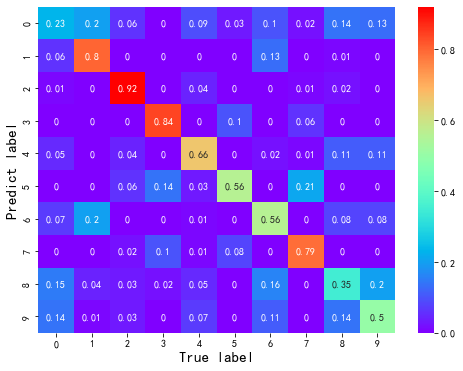

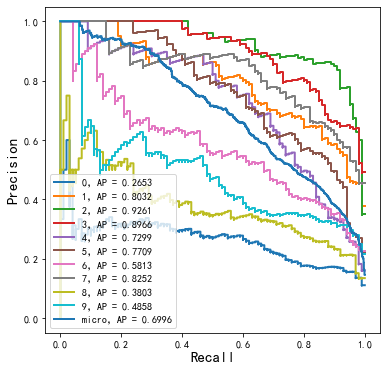

In [90]:
#创建CNN+catboost模型，此处核函数为线性核函数
cv_params  = {'depth': [8,9,10,11,12,13,14]}
other_params = {'iterations': 800,'learning_rate': 0.09}
cbc = CatBoostClassifier(eval_metric="AUC", depth=4, iterations=500, l2_leaf_reg=1,learning_rate=0.1)
                
cbc.fit(x_temp1, y_train_transform)
cbc_pred_test=cbc.predict_proba(x_temp2)
cbc_pred_test_1=np.argmax(cbc_pred_test,axis=1)

#计算catboost的结果
acc,pre,rec,f1=get_result(y_test_transform,cbc_pred_test_1)
print('CNN+catboost\'s result \n accuracy= {} \t precision= {} \t recall= {} \t F1= {}'.format(round(acc,5),round(pre,5),round(rec,5),round(f1,5)))

#catboost分类结果的混淆矩阵   
plt_heatmap(y_test_transform,cbc_pred_test_1,title=None,path=None)

#catboost的P-R曲线    
precision, recall, average_precision = micro_PR(one_hot_test_labels,cbc_pred_test)
plot_a_model_PR_curve(precision,recall,average_precision,title=None,path=None)


#回收结果
collect_every_model_result.append([acc,pre,rec,f1,'CNN+catoost'])
collect_every_model_PR.append([precision, recall, average_precision,'CNN+catoost'])